In [1]:
import os
import itertools as itt
from typing import Optional, Tuple, List

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

import astro30m
from cubes_api import Cube, Map

plt.rc("text", usetex=True)

figure_template = os.path.join("figures-regimes", "map-regimes-{}.png")

In [2]:
all_regimes = {
    "dust-av": {
        "all": None,
        "0": [None, 1],
        "1": [1, 2],
        "2": [2, 6],
        "3": [6, 15],
        "4": [15, None]
    },
    "dust-g0": {
        "all": None,
        "0": [None, 1e1],
        "1": [1e1, 3e1],
        "2": [3e1, 3e2],
        "3": [3e2, 1e4],
        "4": [1e4, None]
    }
}

In [3]:
def get_mask(params: List[Map], regimes: List[Optional[Tuple[Optional[float], Optional[float]]]]):
    assert len(params) == len(regimes)
    assert len(params) > 0

    mask = Map.ones_like(params[0])
    for param, reg in zip(params, regimes):
        if reg is None:
            continue
        if reg[0] is not None:
            mask = mask & (param >= reg[0])
        if reg[1] is not None:
            mask = mask & (param < reg[1])

    return mask

In [4]:
param_names = [
    "dust-av",
    "dust-g0"
]

line_names = [
    "12co10",
    "13co10",
    "hcop10",
    "hcn10",
    "c18o10",
    "12cs21",
    "hnc10",
    "12cn10",
    "32so21",
    "c17o10",
    "c3h2",
    "ch3oh21",
    "n2hp10",
    "cch10",

    "h2co",
    "h13cop10"
]

In [5]:
integrals = {line: astro30m.load_line_integral(line, 2020) for line in line_names}
noise_maps = {line: astro30m.load_noise_map(line, 2020, for_integral=True) for line in line_names}

params = {name: astro30m.load_phys_quantity(name, 2020) for name in param_names}

### Segmentation with respect to Av

In [6]:
jet = plt.get_cmap("jet")

cmap = colors.ListedColormap([jet(0), jet(0.33), jet(0.67), jet(0.99)])
norm = colors.BoundaryNorm(np.arange(-0.5,4), cmap.N)

In [7]:
param = "dust-av"
regimes = ["1", "2", "3", "4"]

m = Map.zeros_like(params[param_names[0]]) - 1

for i, reg in enumerate(regimes, 1):
    mask = get_mask([params[param]], [all_regimes[param][reg]])
    m += i * mask

m = (m < 0).where(np.nan, m)

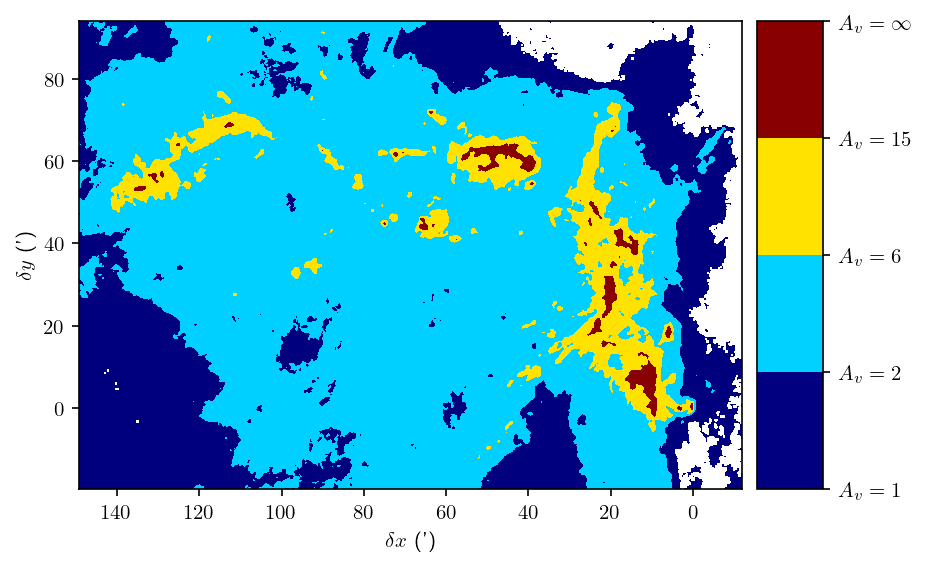

In [8]:
plt.figure(dpi=150)

ticklabels = [1, 2, 6, 15, "\\infty"]
ticklabels = [f"${astro30m.latex_quantity('dust-av')}={v}$" for v in ticklabels]

_, __, cbar = m.plot(cmap=cmap, norm=norm)
cbar.ax.set_yticks([t - 0.5 for t in range(cmap.N+1)], labels=ticklabels)

plt.savefig(figure_template.format("av"), bbox_inches='tight')
plt.show()

### Segmentation with respect to G0

In [9]:
param = "dust-g0"
regimes = ["1", "2", "3", "4"]

m = Map.zeros_like(params[param_names[0]]) - 1

for i, reg in enumerate(regimes, 1):
    mask = get_mask([params[param]], [all_regimes[param][reg]])
    m += i * mask

m = (m < 0).where(np.nan, m)

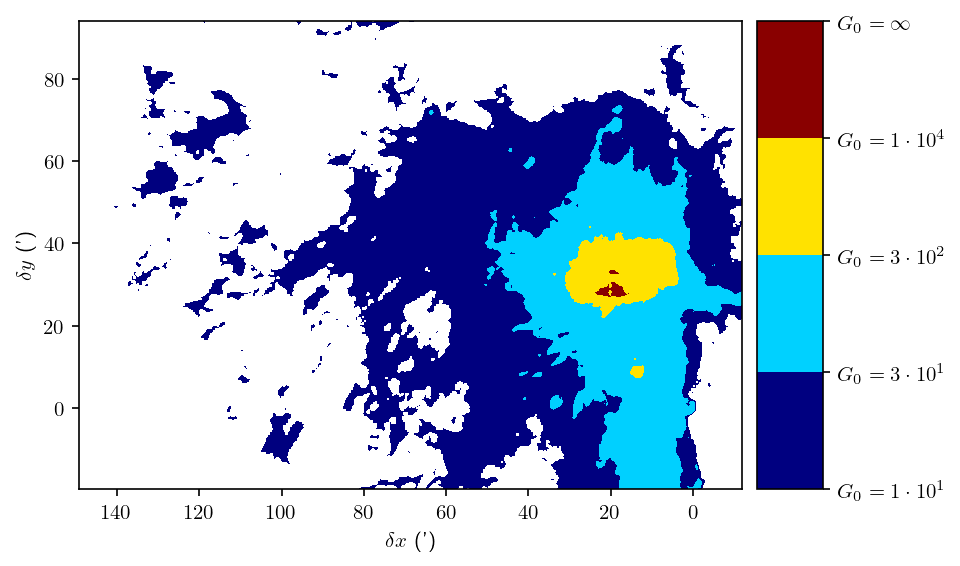

In [10]:
plt.figure(dpi=150)

ticklabels = ["1\\cdot10^1", "3\\cdot10^1", "3\\cdot10^2", "1\\cdot10^4", "\\infty"]
ticklabels = [f"${astro30m.latex_quantity('dust-g0')}={v}$" for v in ticklabels]

_, __, cbar = m.plot(cmap=cmap, norm=norm)
cbar.ax.set_yticks([t - 0.5 for t in range(cmap.N+1)], labels=ticklabels)

plt.savefig(figure_template.format("g0"), bbox_inches='tight')
plt.show()

### Segmentation with respect to (Av, G0)

In [11]:
def jet_alpha(value, alpha):
    assert 0 <= alpha <= 1 
    t = list(plt.get_cmap("jet")(value))
    t[3] = alpha
    return tuple(t)

values = [0., 0.33, 0.67, 0.99]
alphas = [0.25, 0.5, 0.75, 1.0] #[0.4, 0.6, 0.8, 1.0]
cmap = colors.ListedColormap(
    [jet_alpha(values[0], alpha) for alpha in alphas]\
    + [jet_alpha(values[1], alpha) for alpha in alphas]\
    + [jet_alpha(values[2], alpha) for alpha in alphas]\
    + [jet_alpha(values[3], alpha) for alpha in alphas]
)
norm = colors.BoundaryNorm(np.arange(-0.5, 16), cmap.N)

In [12]:
ps = ["dust-av", "dust-g0"]
regimes = ["1", "2", "3", "4"]

m = Map.zeros_like(params[param_names[0]]) - 1

for i, regs in enumerate(itt.product(regimes, regimes), 1):
    mask = get_mask(
        [params[ps[0]], params[ps[1]]],
        [all_regimes[ps[0]][regs[0]], all_regimes[ps[1]][regs[1]]]
    )
    m += i * mask

m = (m < 0).where(np.nan, m)

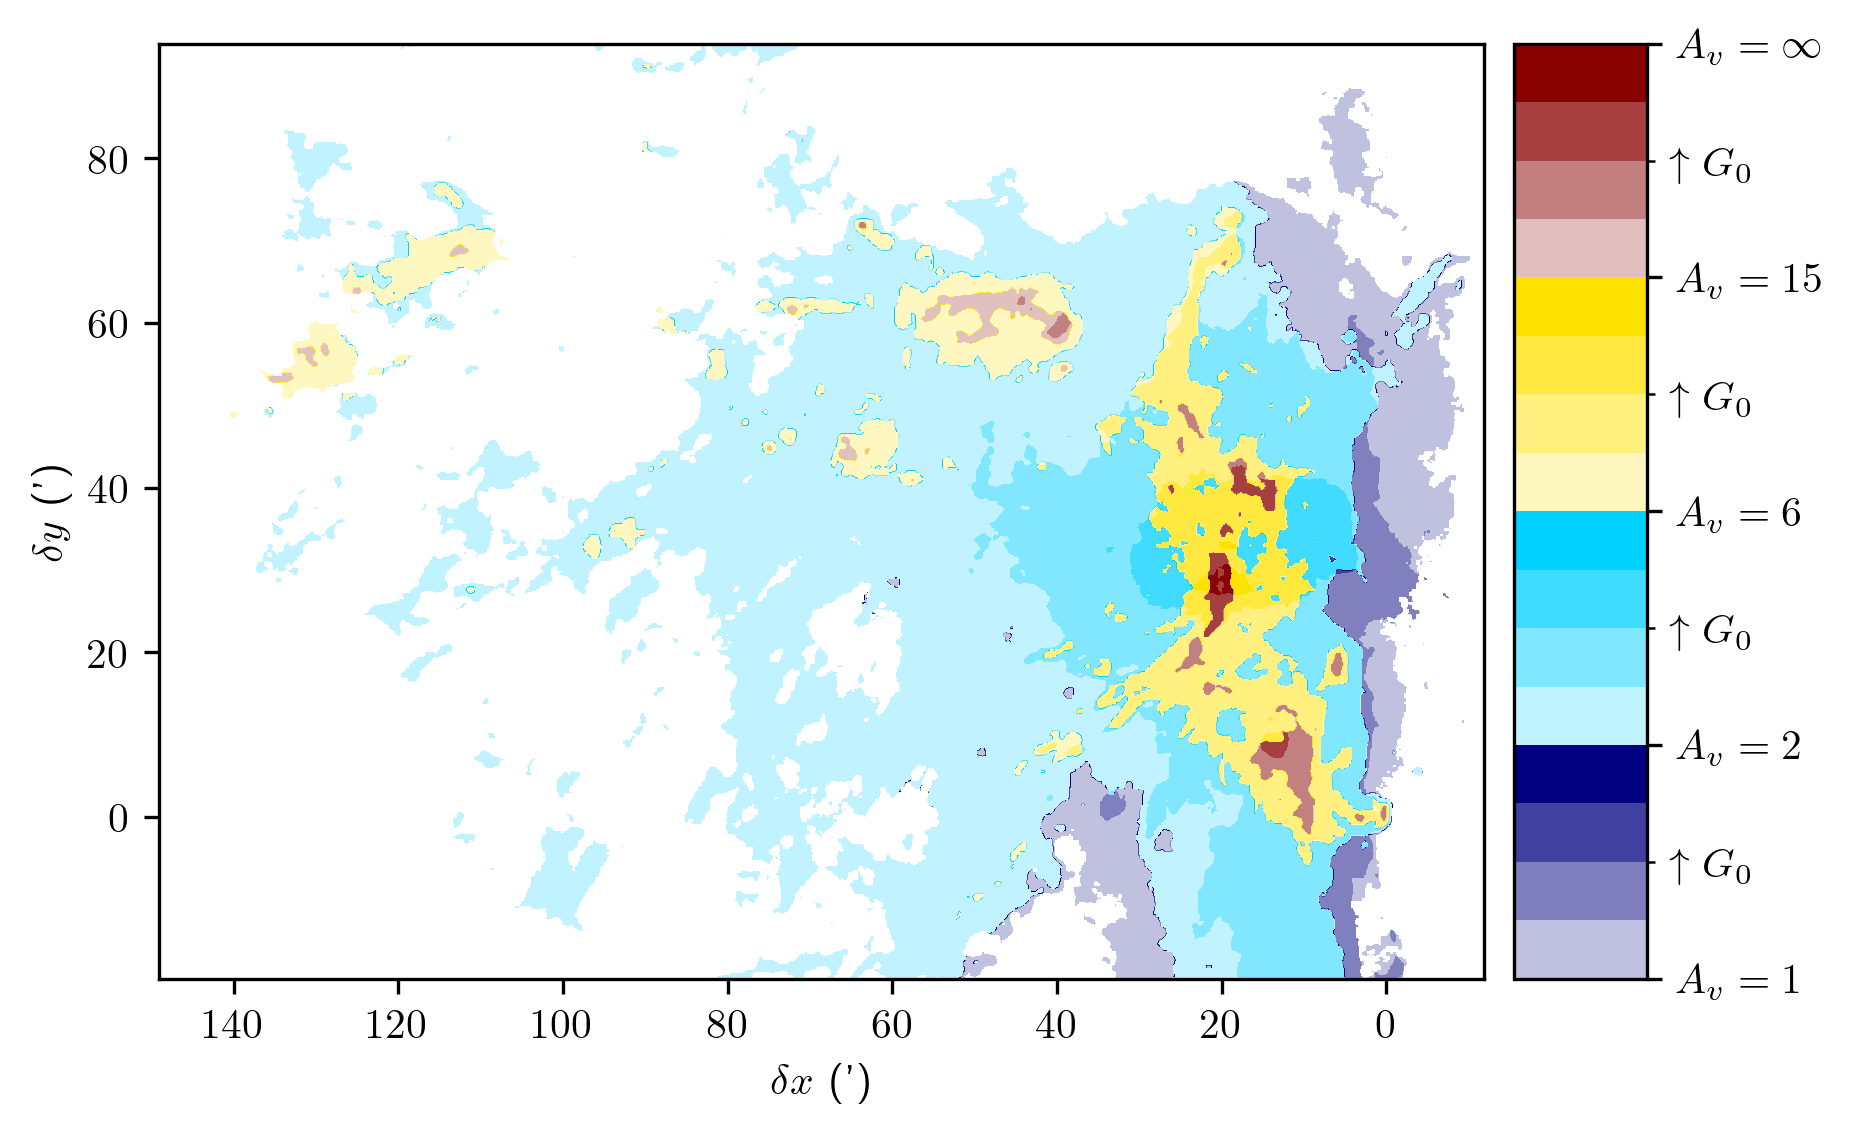

In [13]:
plt.figure(dpi=300)

ticklabels = ["1", "2", "6", "15", "\\infty"]
ticklabels = [f"${astro30m.latex_quantity('dust-av')}={v}$" for v in ticklabels]

_, __, cbar = m.plot(cmap=cmap, norm=norm)
cbar.ax.set_yticks([t - 0.5 for t in [0, 4, 8, 12, 16]], labels=ticklabels)
cbar.ax.set_yticks([t - 0.5 for t in [2, 6, 10, 14]], labels=4*[f"$\\uparrow {astro30m.latex_quantity('dust-g0')}$"], minor=True)

plt.savefig(figure_template.format("av-g0"), bbox_inches='tight')
plt.show()

In [14]:
ps = ["dust-g0", "dust-av"]
regimes = ["1", "2", "3", "4"]

m = Map.zeros_like(params[param_names[0]]) - 1

for i, regs in enumerate(itt.product(regimes, regimes), 1):
    mask = get_mask(
        [params[ps[0]], params[ps[1]]],
        [all_regimes[ps[0]][regs[0]], all_regimes[ps[1]][regs[1]]]
    )
    m += i * mask

m = (m < 0).where(np.nan, m)

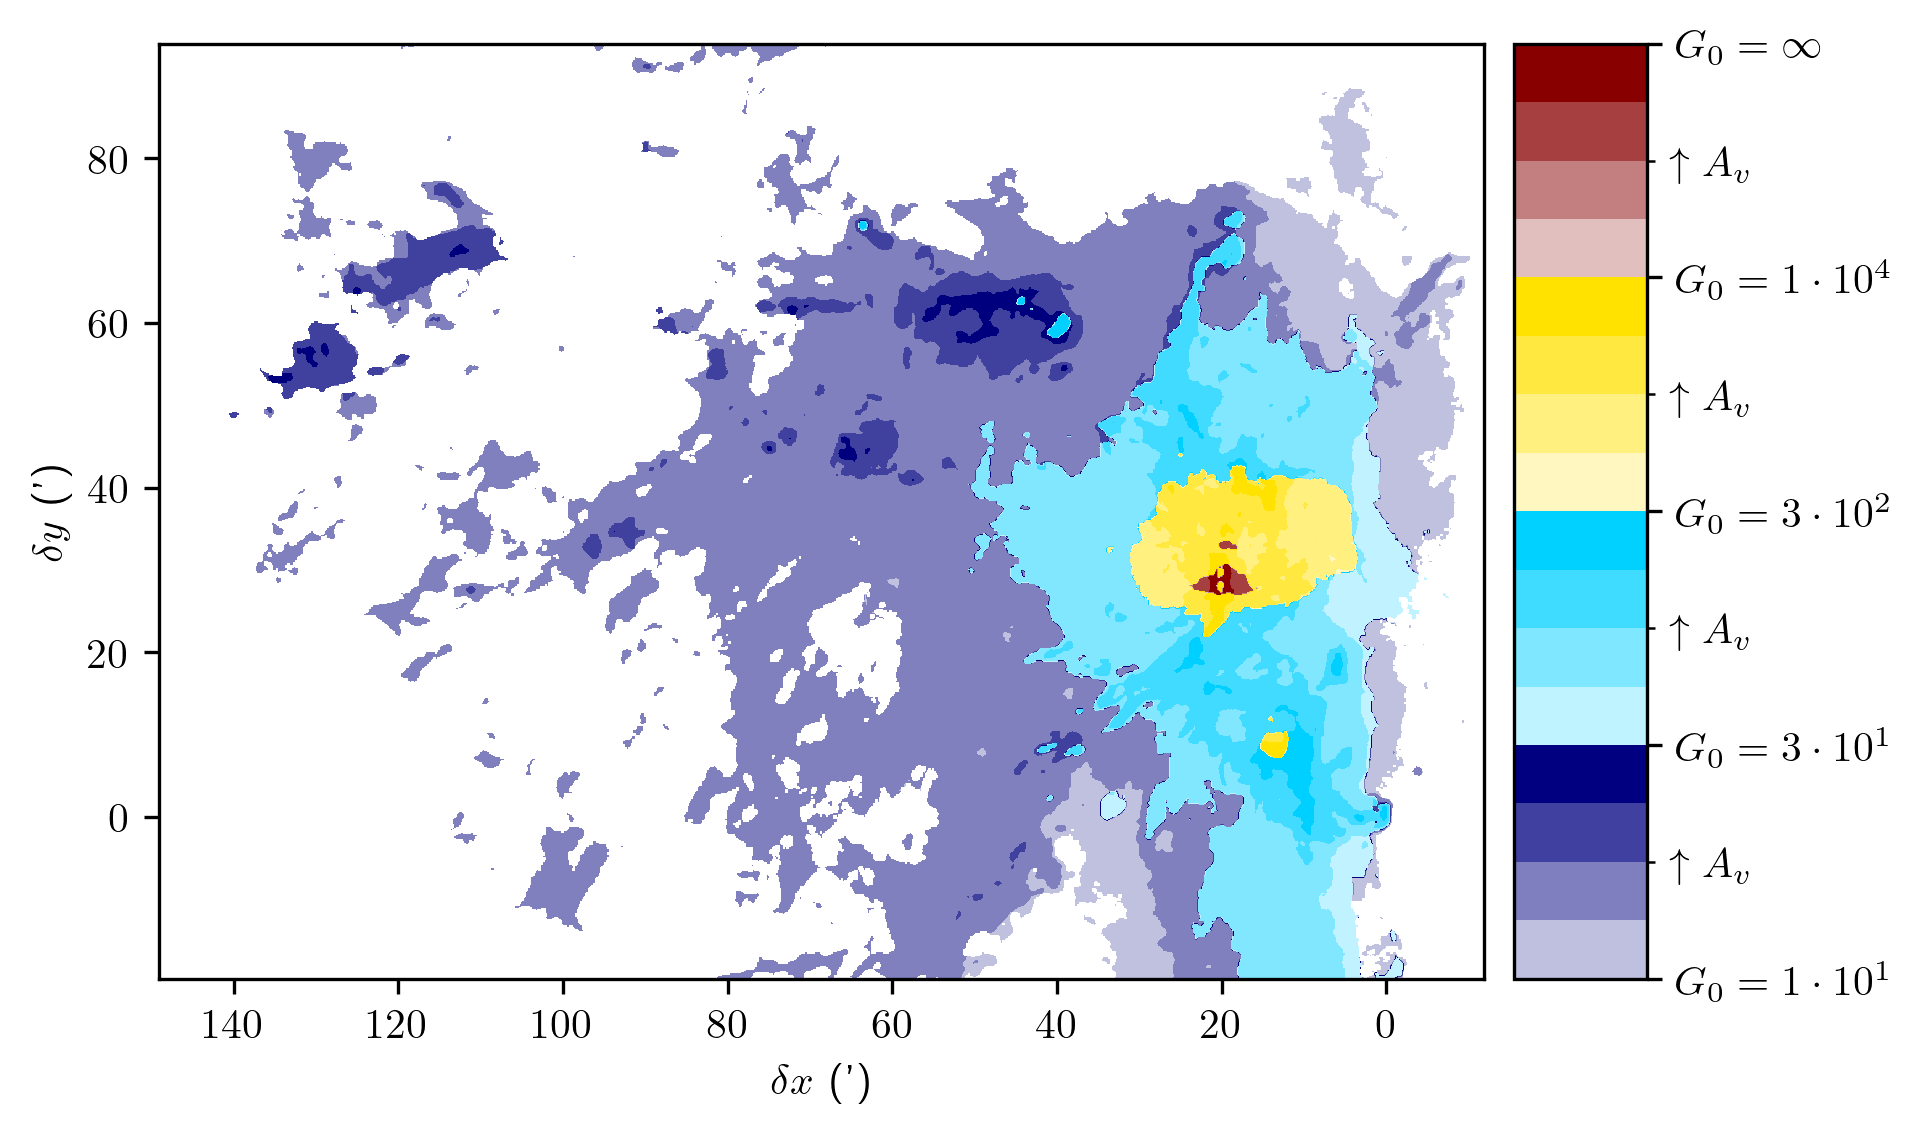

In [15]:
plt.figure(dpi=300)

ticklabels = ["1\\cdot10^1", "3\\cdot10^1", "3\\cdot10^2", "1\\cdot10^4", "\\infty"]
ticklabels = [f"${astro30m.latex_quantity('dust-g0')}={v}$" for v in ticklabels]

_, __, cbar = m.plot(cmap=cmap, norm=norm)
cbar.ax.set_yticks([t - 0.5 for t in [0, 4, 8, 12, 16]], labels=ticklabels)
cbar.ax.set_yticks([t - 0.5 for t in [2, 6, 10, 14]], labels=4*[f"$\\uparrow {astro30m.latex_quantity('dust-av')}$"], minor=True)

plt.savefig(figure_template.format("g0-av"), bbox_inches='tight')
plt.show()